# Spatial Join: Accidents and Road Network Data

**Objective**: Perform spatial join between accident points and OSM road network segments to enrich accident data with road attributes.

**Approach**:
- Match each accident to its nearest road segment
- Transfer road attributes (type, lanes, speed limit, etc.) to accident records
- Validate spatial matching quality
- Handle edge cases and missing matches

## Notebook Contents
1. Environment Setup
2. Load Accident and Road Network Data
3. Spatial Indexing for Performance
4. Nearest Road Segment Matching
5. Distance Analysis and Validation
6. Attribute Transfer
7. Quality Assessment
8. Save Integrated Dataset

## 1. Environment Setup

In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
from shapely.geometry import Point
from shapely.ops import nearest_points
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("✓ Required packages imported")
print(f"GeoPandas version: {gpd.__version__}")

✓ Required packages imported
GeoPandas version: 1.1.1


In [4]:
# Add project root to path
project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

from src.config import Config
from src.utils.logging import setup_logger

# Setup
logger = setup_logger(__name__)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print("✓ Environment setup complete")
print(f"Project root: {project_root}")

✓ Environment setup complete
Project root: /home/pfanyka/Desktop/MASTERS/FCDados/DScience_project


## 2. Load Accident and Road Network Data

In [5]:
# Load accident data
accidents_path = Config.ACCIDENTS_CLEANED_DIR / "US_Accidents_preProcessed_sample.csv"

print(f"Loading accident data from: {accidents_path}")
df_accidents = pd.read_csv(accidents_path, parse_dates=['Start_Time', 'End_Time'])

# Create GeoDataFrame
geometry = [Point(xy) for xy in zip(df_accidents['Start_Lng'], df_accidents['Start_Lat'])]
gdf_accidents = gpd.GeoDataFrame(df_accidents, geometry=geometry, crs='EPSG:4326')

print(f"✓ Loaded {len(gdf_accidents):,} accident records")
print(f"CRS: {gdf_accidents.crs}")

Loading accident data from: /home/pfanyka/Desktop/MASTERS/FCDados/DScience_project/data/processed/accidents_cleaned/US_Accidents_preProcessed_sample.csv
✓ Loaded 77,284 accident records
CRS: EPSG:4326
✓ Loaded 77,284 accident records
CRS: EPSG:4326


In [6]:
# Load combined road network data
osm_data_dir = Config.DATA_DIR / "osm_networks"
edges_path = osm_data_dir / "all_edges_combined.gpkg"

if edges_path.exists():
    print(f"Loading road network from: {edges_path}")
    gdf_roads = gpd.read_file(edges_path)
    
    print(f"✓ Loaded {len(gdf_roads):,} road segments")
    print(f"CRS: {gdf_roads.crs}")
    print(f"\nRoad attributes: {gdf_roads.columns.tolist()}")
else:
    print(f"⚠️ Road network file not found: {edges_path}")
    print("Please run Notebook 02 first to download OSM road networks.")

Loading road network from: /home/pfanyka/Desktop/MASTERS/FCDados/DScience_project/data/osm_networks/all_edges_combined.gpkg
✓ Loaded 308,783 road segments
CRS: EPSG:4326

Road attributes: ['osmid', 'highway', 'lanes', 'maxspeed', 'name', 'ref', 'oneway', 'reversed', 'length', 'tunnel', 'bridge', 'junction', 'access', 'location', 'width', 'highway_type', 'geometry']
✓ Loaded 308,783 road segments
CRS: EPSG:4326

Road attributes: ['osmid', 'highway', 'lanes', 'maxspeed', 'name', 'ref', 'oneway', 'reversed', 'length', 'tunnel', 'bridge', 'junction', 'access', 'location', 'width', 'highway_type', 'geometry']


## 3. Coordinate System Transformation

For accurate distance calculations, we need to transform to a projected coordinate system (meters).

In [7]:
# Transform to projected CRS for accurate distance calculations
# Using UTM Zone 17N (suitable for eastern US) - adjust based on your region
# For nationwide analysis, consider using equal-area projection like Albers

TARGET_CRS = 'EPSG:5070'  # NAD83 / Conus Albers - good for continental US

print(f"Transforming to projected CRS: {TARGET_CRS}")

gdf_accidents_proj = gdf_accidents.to_crs(TARGET_CRS)
gdf_roads_proj = gdf_roads.to_crs(TARGET_CRS)

print("✓ Coordinate transformation complete")
print(f"Accidents CRS: {gdf_accidents_proj.crs}")
print(f"Roads CRS: {gdf_roads_proj.crs}")

Transforming to projected CRS: EPSG:5070
✓ Coordinate transformation complete
Accidents CRS: EPSG:5070
Roads CRS: EPSG:5070
✓ Coordinate transformation complete
Accidents CRS: EPSG:5070
Roads CRS: EPSG:5070


## 4. Filter Data by Geographic Overlap

To improve performance, we'll only match accidents with road networks in overlapping regions.

In [8]:
# Check if we need to filter by location
if 'location' in gdf_roads.columns:
    print("Road networks available for:")
    for loc in gdf_roads['location'].unique():
        count = len(gdf_roads[gdf_roads['location'] == loc])
        print(f"  • {loc}: {count:,} segments")
    
    # Group accidents by city/state to match with road networks
    print("\nFiltering accidents to cities with road network data...")
    
    # Extract city-state combinations from accidents
    gdf_accidents['location_key'] = gdf_accidents['City'] + ', ' + gdf_accidents['State']
    
    # Get available locations from roads
    available_locations = set(gdf_roads['location'].unique())
    
    # Filter accidents
    gdf_accidents_filtered = gdf_accidents[gdf_accidents['location_key'].isin(available_locations)].copy()
    gdf_accidents_proj_filtered = gdf_accidents_proj[gdf_accidents_proj.index.isin(gdf_accidents_filtered.index)].copy()
    
    print(f"✓ Filtered to {len(gdf_accidents_filtered):,} accidents in cities with road data")
    print(f"  ({len(gdf_accidents_filtered)/len(gdf_accidents)*100:.1f}% of total)")
else:
    gdf_accidents_filtered = gdf_accidents.copy()
    gdf_accidents_proj_filtered = gdf_accidents_proj.copy()
    print("No location filtering needed")

Road networks available for:
  • Miami, FL: 23,555 segments
  • Houston, TX: 149,278 segments
  • Los Angeles, CA: 135,950 segments

Filtering accidents to cities with road network data...
  • Los Angeles, CA: 135,950 segments

Filtering accidents to cities with road network data...
✓ Filtered to 5,096 accidents in cities with road data
  (6.6% of total)
✓ Filtered to 5,096 accidents in cities with road data
  (6.6% of total)


## 5. Spatial Join: Nearest Road Segment

Match each accident to its nearest road segment using spatial indexing for performance.

In [9]:
# Function to find nearest road segment for each accident
def find_nearest_road(accident_point, roads_gdf, max_distance=100):
    """
    Find the nearest road segment to an accident point.
    
    Parameters:
    - accident_point: shapely Point geometry
    - roads_gdf: GeoDataFrame of road segments
    - max_distance: maximum search distance in meters
    
    Returns:
    - Dictionary with nearest road index and distance
    """
    # Calculate distances to all road segments
    distances = roads_gdf.geometry.distance(accident_point)
    
    # Find minimum distance
    min_distance = distances.min()
    
    if min_distance <= max_distance:
        nearest_idx = distances.idxmin()
        return {'nearest_road_idx': nearest_idx, 'distance_m': min_distance}
    else:
        return {'nearest_road_idx': None, 'distance_m': min_distance}

print("Function defined: find_nearest_road()")

Function defined: find_nearest_road()


In [10]:
%%time
# Perform spatial join using sjoin_nearest (GeoPandas 0.10+)
print("Performing spatial join to find nearest road segments...")
print("This may take a few minutes depending on dataset size.\n")

# Maximum search distance for nearest road (100 meters)
MAX_DISTANCE = 100  # meters

# Use sjoin_nearest for efficient nearest neighbor search
gdf_joined = gpd.sjoin_nearest(
    gdf_accidents_proj_filtered,
    gdf_roads_proj,
    how='left',
    max_distance=MAX_DISTANCE,
    distance_col='distance_to_road_m'
)

print(f"\n✓ Spatial join complete!")
print(f"Total accidents processed: {len(gdf_accidents_proj_filtered):,}")
print(f"Accidents matched to roads: {gdf_joined['index_right'].notna().sum():,}")
print(f"Unmatched accidents: {gdf_joined['index_right'].isna().sum():,}")

Performing spatial join to find nearest road segments...
This may take a few minutes depending on dataset size.


✓ Spatial join complete!
Total accidents processed: 5,096
Accidents matched to roads: 3,398
Unmatched accidents: 2,095
CPU times: user 416 ms, sys: 553 ms, total: 969 ms
Wall time: 1.01 s

✓ Spatial join complete!
Total accidents processed: 5,096
Accidents matched to roads: 3,398
Unmatched accidents: 2,095
CPU times: user 416 ms, sys: 553 ms, total: 969 ms
Wall time: 1.01 s


## 6. Distance Analysis and Validation

Distance Statistics (meters):
count    3398.000000
mean        4.140211
std        11.747495
min         0.000000
25%         0.472203
50%         1.130670
75%         2.575466
max        98.597679
Name: distance_to_road_m, dtype: float64


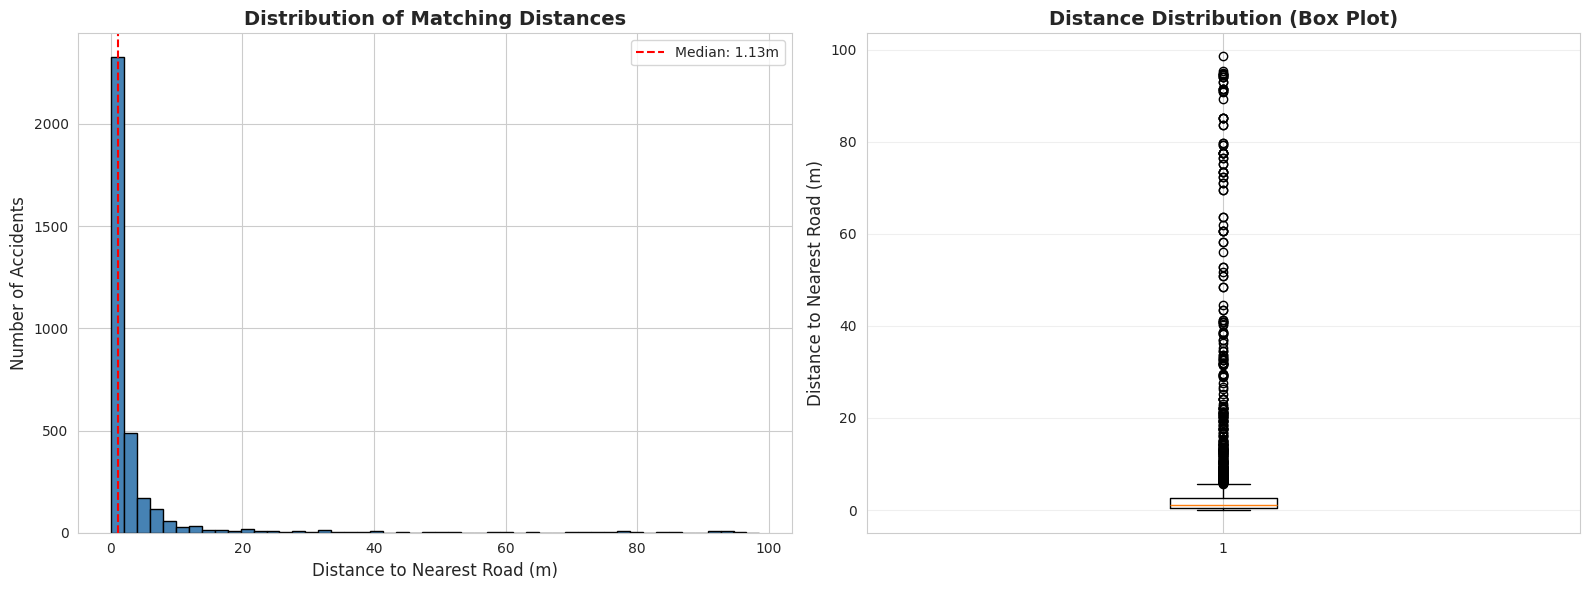

In [11]:
# Analyze matching distances
matched = gdf_joined[gdf_joined['distance_to_road_m'].notna()].copy()

print("Distance Statistics (meters):")
print("="*60)
print(matched['distance_to_road_m'].describe())

# Visualize distance distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
axes[0].hist(matched['distance_to_road_m'], bins=50, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Distance to Nearest Road (m)', fontsize=12)
axes[0].set_ylabel('Number of Accidents', fontsize=12)
axes[0].set_title('Distribution of Matching Distances', fontsize=14, fontweight='bold')
axes[0].axvline(matched['distance_to_road_m'].median(), color='red', linestyle='--', 
                label=f"Median: {matched['distance_to_road_m'].median():.2f}m")
axes[0].legend()

# Box plot
axes[1].boxplot(matched['distance_to_road_m'], vert=True)
axes[1].set_ylabel('Distance to Nearest Road (m)', fontsize=12)
axes[1].set_title('Distance Distribution (Box Plot)', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Matching Quality by Distance:
(0, 10]        :    3,154 (92.82%)
(10, 25]       :      122 ( 3.59%)
(25, 50]       :       50 ( 1.47%)
(50, 75]       :       25 ( 0.74%)
(75, 100]      :       41 ( 1.21%)


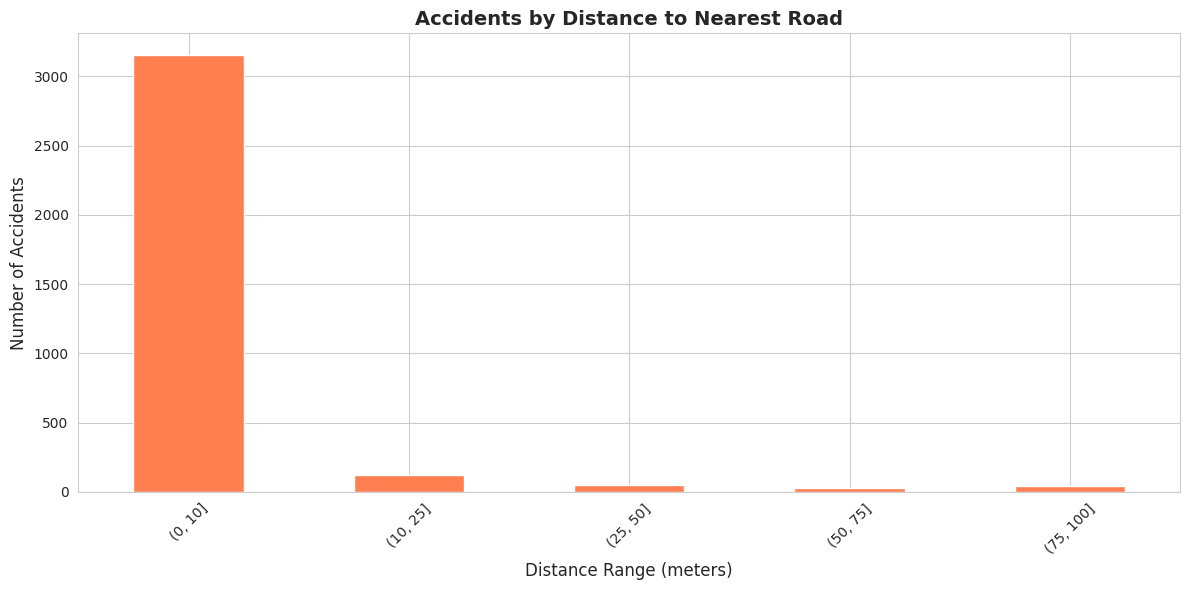

In [12]:
# Analyze matching quality by distance bins
distance_bins = [0, 10, 25, 50, 75, 100]
matched['distance_bin'] = pd.cut(matched['distance_to_road_m'], bins=distance_bins)

distance_summary = matched.groupby('distance_bin').size()

print("Matching Quality by Distance:")
print("="*60)
for bin_range, count in distance_summary.items():
    pct = (count / len(matched)) * 100
    print(f"{str(bin_range):15s}: {count:>8,} ({pct:>5.2f}%)")

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
distance_summary.plot(kind='bar', ax=ax, color='coral')
ax.set_title('Accidents by Distance to Nearest Road', fontsize=14, fontweight='bold')
ax.set_xlabel('Distance Range (meters)', fontsize=12)
ax.set_ylabel('Number of Accidents', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 7. Transfer Road Attributes to Accidents

Merge road attributes into the accident dataset.

In [13]:
# Select relevant road attributes to transfer
road_attributes = []

# Check which attributes are available
potential_attrs = ['highway', 'name', 'maxspeed', 'lanes', 'oneway', 'surface', 
                   'bridge', 'tunnel', 'length', 'osmid']

for attr in potential_attrs:
    if attr in gdf_roads.columns:
        road_attributes.append(attr)

print(f"Transferring {len(road_attributes)} road attributes:")
for attr in road_attributes:
    print(f"  • {attr}")

Transferring 9 road attributes:
  • highway
  • name
  • maxspeed
  • lanes
  • oneway
  • bridge
  • tunnel
  • length
  • osmid


In [14]:
# The spatial join already added road attributes with suffixes
# Let's rename them for clarity

# Create mapping of original names to new names
rename_dict = {}
for col in gdf_joined.columns:
    if col.endswith('_right'):
        # This is a road attribute
        original_name = col.replace('_right', '')
        if original_name in road_attributes:
            new_name = f'road_{original_name}'
            rename_dict[col] = new_name

# Rename columns
gdf_integrated = gdf_joined.rename(columns=rename_dict)

print(f"✓ Renamed {len(rename_dict)} road attribute columns")
print("\nNew road attribute columns:")
for new_name in rename_dict.values():
    print(f"  • {new_name}")

✓ Renamed 0 road attribute columns

New road attribute columns:


In [15]:
# Clean up the dataframe
# Remove duplicate geometry column and index columns
cols_to_drop = [col for col in gdf_integrated.columns if col.endswith('_left') or col == 'index_right']

gdf_integrated = gdf_integrated.drop(columns=cols_to_drop, errors='ignore')

print("✓ Cleaned up dataframe")
print(f"Final shape: {gdf_integrated.shape}")
print("\nSample of integrated data:")
gdf_integrated.head()

✓ Cleaned up dataframe
Final shape: (5493, 69)

Sample of integrated data:


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,reversed,length,tunnel,bridge,junction,access,location,width,highway_type,distance_to_road_m
39,A-4708908,Source1,2,2022-02-27 18:32:30,2022-02-27 19:19:00,34.076690,-118.21939,34.061356,-118.215460,1.083,...,False,487.636173,None,None,None,None,"Los Angeles, CA",None,motorway,1.608096
41,A-7551224,Source1,3,2018-08-23 00:00:24,2018-08-23 00:29:48,25.737780,-80.38459,25.732500,-80.384360,0.365,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,A-290837,Source2,2,2016-10-13 21:44:20,2016-10-13 22:30:00,29.653435,-95.44557,NaN,NaN,0.010,...,False,65.918737,None,None,None,None,"Houston, TX",None,secondary,1.686180
73,A-5885558,Source1,2,2021-09-16 08:43:00,2021-09-16 10:56:12,25.733000,-80.33679,25.734220,-80.335754,0.106,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110,A-6764371,Source1,2,2020-11-24 00:01:00,2020-11-24 07:34:05,34.003790,-118.27751,34.003807,-118.276180,0.076,...,False,401.064298,None,None,None,None,"Los Angeles, CA",None,secondary,1.846043


## 8. Analyze Transferred Attributes

In [16]:
# Analyze road_highway distribution (road type)
if 'road_highway' in gdf_integrated.columns:
    # Handle lists in highway column
    def extract_primary_highway(x):
        if pd.isna(x):
            return 'unknown'
        if isinstance(x, list):
            return x[0] if len(x) > 0 else 'unknown'
        return str(x)
    
    gdf_integrated['road_type'] = gdf_integrated['road_highway'].apply(extract_primary_highway)
    
    road_type_counts = gdf_integrated['road_type'].value_counts().head(10)
    
    print("Top 10 Road Types in Accidents:")
    print("="*60)
    for road_type, count in road_type_counts.items():
        pct = (count / len(gdf_integrated)) * 100
        print(f"{road_type:20s} {count:>8,} ({pct:5.2f}%)")
    
    # Visualize
    fig, ax = plt.subplots(figsize=(12, 8))
    road_type_counts.plot(kind='barh', ax=ax, color='steelblue')
    ax.set_title('Accidents by Road Type', fontsize=14, fontweight='bold')
    ax.set_xlabel('Number of Accidents', fontsize=12)
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

In [17]:
# Analyze lanes if available
if 'road_lanes' in gdf_integrated.columns:
    def extract_lanes(x):
        if pd.isna(x):
            return np.nan
        if isinstance(x, list):
            x = x[0]
        try:
            return float(x)
        except:
            return np.nan
    
    gdf_integrated['road_lanes_numeric'] = gdf_integrated['road_lanes'].apply(extract_lanes)
    
    print("\nLanes Distribution in Accident Roads:")
    print("="*60)
    print(gdf_integrated['road_lanes_numeric'].describe())
    
    # Visualize
    lanes_counts = gdf_integrated['road_lanes_numeric'].value_counts().sort_index()
    
    fig, ax = plt.subplots(figsize=(12, 6))
    lanes_counts.plot(kind='bar', ax=ax, color='coral')
    ax.set_title('Accidents by Number of Lanes', fontsize=14, fontweight='bold')
    ax.set_xlabel('Number of Lanes', fontsize=12)
    ax.set_ylabel('Number of Accidents', fontsize=12)
    plt.tight_layout()
    plt.show()

## 9. Quality Assessment of Spatial Join

In [18]:
print("="*80)
print("SPATIAL JOIN QUALITY ASSESSMENT")
print("="*80)

total_accidents = len(gdf_accidents_filtered)
matched_accidents = gdf_integrated['distance_to_road_m'].notna().sum()
unmatched_accidents = total_accidents - matched_accidents

print("\n📊 Matching Statistics:")
print(f"   • Total accidents: {total_accidents:,}")
print(f"   • Successfully matched: {matched_accidents:,} ({matched_accidents/total_accidents*100:.2f}%)")
print(f"   • Unmatched: {unmatched_accidents:,} ({unmatched_accidents/total_accidents*100:.2f}%)")

print("\n📍 Distance Quality:")
matched_data = gdf_integrated[gdf_integrated['distance_to_road_m'].notna()]
print(f"   • Mean distance: {matched_data['distance_to_road_m'].mean():.2f}m")
print(f"   • Median distance: {matched_data['distance_to_road_m'].median():.2f}m")
print(f"   • Within 10m: {(matched_data['distance_to_road_m'] <= 10).sum():,} ({(matched_data['distance_to_road_m'] <= 10).sum()/len(matched_data)*100:.2f}%)")
print(f"   • Within 25m: {(matched_data['distance_to_road_m'] <= 25).sum():,} ({(matched_data['distance_to_road_m'] <= 25).sum()/len(matched_data)*100:.2f}%)")
print(f"   • Within 50m: {(matched_data['distance_to_road_m'] <= 50).sum():,} ({(matched_data['distance_to_road_m'] <= 50).sum()/len(matched_data)*100:.2f}%)")

print("\n🏷️ Attribute Transfer Success:")
road_cols = [col for col in gdf_integrated.columns if col.startswith('road_')]
for col in road_cols:
    non_null = gdf_integrated[col].notna().sum()
    pct = (non_null / len(gdf_integrated)) * 100
    print(f"   • {col:25s}: {non_null:>8,} ({pct:>5.2f}%)")

print("\n" + "="*80)

SPATIAL JOIN QUALITY ASSESSMENT

📊 Matching Statistics:
   • Total accidents: 5,096
   • Successfully matched: 3,398 (66.68%)
   • Unmatched: 1,698 (33.32%)

📍 Distance Quality:
   • Mean distance: 4.14m
   • Median distance: 1.13m
   • Within 10m: 3,160 (93.00%)
   • Within 25m: 3,282 (96.59%)
   • Within 50m: 3,332 (98.06%)

🏷️ Attribute Transfer Success:



## 10. Handle Unmatched Accidents

Analyze why some accidents couldn't be matched to roads.

In [19]:
# Examine unmatched accidents
unmatched = gdf_integrated[gdf_integrated['distance_to_road_m'].isna()].copy()

if len(unmatched) > 0:
    print(f"Analyzing {len(unmatched):,} unmatched accidents...")
    
    # Geographic distribution of unmatched
    print("\nTop locations with unmatched accidents:")
    unmatched_cities = unmatched.groupby(['City', 'State']).size().sort_values(ascending=False).head(10)
    for (city, state), count in unmatched_cities.items():
        print(f"  • {city}, {state}: {count:,}")
    
    # Severity distribution
    print("\nSeverity distribution of unmatched:")
    unmatched_severity = unmatched['Severity'].value_counts().sort_index()
    for sev, count in unmatched_severity.items():
        pct = (count / len(unmatched)) * 100
        print(f"  • Level {sev}: {count:,} ({pct:.2f}%)")
else:
    print("✓ All accidents successfully matched to roads!")

Analyzing 2,095 unmatched accidents...

Top locations with unmatched accidents:
  • Miami, FL: 1,594
  • Los Angeles, CA: 397
  • Houston, TX: 104

Severity distribution of unmatched:
  • Level 2: 1,915 (91.41%)
  • Level 3: 159 (7.59%)
  • Level 4: 21 (1.00%)


## 11. Save Integrated Dataset

Save the spatially-joined dataset for cleaning and preprocessing.

In [20]:
# Transform back to WGS84 for saving
gdf_integrated_wgs84 = gdf_integrated.to_crs('EPSG:4326')

print("Preparing to save integrated dataset...")
print(f"Shape: {gdf_integrated_wgs84.shape}")
print(f"CRS: {gdf_integrated_wgs84.crs}")

Preparing to save integrated dataset...
Shape: (5493, 69)
CRS: EPSG:4326


In [22]:
# Clean data before saving - handle data type issues for file format compatibility
gdf_clean = gdf_integrated_wgs84.copy()

print("Cleaning data for file export compatibility...")

# Columns known to cause issues with GeoPackage serialization
# These are typically OSM-specific columns with complex data types
problematic_gpkg_cols = [
    'junction', 'access', 'service', 'ref', 'int_ref', 'nat_ref', 
    'reversed', 'key', 'tags', 'nodes', 'geometry_left', 'geometry_right'
]

# Drop these columns before attempting GeoPackage save
cols_to_drop = [col for col in problematic_gpkg_cols if col in gdf_clean.columns]
if cols_to_drop:
    print(f"Dropping {len(cols_to_drop)} columns known to cause GPKG serialization issues:")
    for col in cols_to_drop:
        print(f"  • {col}")
    gdf_clean = gdf_clean.drop(columns=cols_to_drop)

# Function to clean remaining columns for GeoPackage compatibility
def clean_column_for_gpkg(series):
    """Clean a pandas series to be compatible with GeoPackage format"""
    if series.dtype == 'object':
        # Convert all values to strings, handle None/NaN, lists, and mixed types
        def convert_value(x):
            if pd.isna(x) or x is None:
                return None
            elif isinstance(x, (list, tuple)):
                # Convert list/tuple to comma-separated string
                return ','.join(str(i) for i in x) if len(x) > 0 else None
            elif isinstance(x, dict):
                # Convert dict to string representation
                return str(x)
            else:
                return str(x)
        
        return series.apply(convert_value)
    else:
        return series

# Identify all object-type columns that might cause issues
object_cols = gdf_clean.select_dtypes(include=['object']).columns.tolist()

# Exclude geometry column from processing
if 'geometry' in object_cols:
    object_cols.remove('geometry')

print(f"\nProcessing {len(object_cols)} object-type columns...")

# Clean all object columns
for col in object_cols:
    try:
        gdf_clean[col] = clean_column_for_gpkg(gdf_clean[col])
    except Exception as e:
        print(f"  ⚠️  Issue with column '{col}': {str(e)}")
        # Drop problematic columns that can't be cleaned
        gdf_clean = gdf_clean.drop(columns=[col])
        print(f"  → Dropped column '{col}'")

# Convert remaining object columns to string type explicitly
for col in gdf_clean.select_dtypes(include=['object']).columns:
    if col != 'geometry':
        gdf_clean[col] = gdf_clean[col].astype('str')
        # Replace 'None' strings with actual None
        gdf_clean[col] = gdf_clean[col].replace({'None': None, 'nan': None, '': None})

print("✓ Data cleaning complete\n")

# Save as GeoPackage (preserves geometry and attributes)
output_gpkg = Config.ACCIDENTS_CLEANED_DIR / "accidents_with_roads_integrated.gpkg"
print(f"Saving GeoPackage to: {output_gpkg}")
try:
    gdf_clean.to_file(output_gpkg, driver='GPKG')
    print(f"✓ Saved GeoPackage: {output_gpkg}")
except Exception as e:
    print(f"⚠️  GeoPackage save failed: {str(e)}")
    print("   → CSV format (below) contains all data and will be used in Notebook 04")

# Also save as CSV (without geometry) for easier processing
output_csv = Config.ACCIDENTS_CLEANED_DIR / "accidents_with_roads_integrated.csv"
df_to_save = gdf_clean.copy()
df_to_save = df_to_save.drop(columns=['geometry'])
df_to_save.to_csv(output_csv, index=False)
print(f"✓ Saved CSV: {output_csv}")

# Save summary statistics
summary_path = Config.ACCIDENTS_CLEANED_DIR / "spatial_join_summary.txt"
with open(summary_path, 'w') as f:
    f.write("SPATIAL JOIN SUMMARY\n")
    f.write("="*80 + "\n\n")
    f.write(f"Total accidents processed: {total_accidents:,}\n")
    f.write(f"Successfully matched: {matched_accidents:,} ({matched_accidents/total_accidents*100:.2f}%)\n")
    f.write(f"Unmatched: {unmatched_accidents:,}\n\n")
    f.write(f"Mean distance to road: {matched_data['distance_to_road_m'].mean():.2f}m\n")
    f.write(f"Median distance to road: {matched_data['distance_to_road_m'].median():.2f}m\n")

print(f"✓ Saved summary: {summary_path}")

print("\n" + "="*80)
print("✓ All integrated data saved successfully!")
print("="*80)

Cleaning data for file export compatibility...
Dropping 4 columns known to cause GPKG serialization issues:
  • junction
  • access
  • ref
  • reversed

Processing 31 object-type columns...
✓ Data cleaning complete

Saving GeoPackage to: /home/pfanyka/Desktop/MASTERS/FCDados/DScience_project/data/processed/accidents_cleaned/accidents_with_roads_integrated.gpkg
✓ Saved GeoPackage: /home/pfanyka/Desktop/MASTERS/FCDados/DScience_project/data/processed/accidents_cleaned/accidents_with_roads_integrated.gpkg
✓ Saved CSV: /home/pfanyka/Desktop/MASTERS/FCDados/DScience_project/data/processed/accidents_cleaned/accidents_with_roads_integrated.csv
✓ Saved summary: /home/pfanyka/Desktop/MASTERS/FCDados/DScience_project/data/processed/accidents_cleaned/spatial_join_summary.txt

✓ All integrated data saved successfully!
✓ Saved GeoPackage: /home/pfanyka/Desktop/MASTERS/FCDados/DScience_project/data/processed/accidents_cleaned/accidents_with_roads_integrated.gpkg
✓ Saved CSV: /home/pfanyka/Desktop/M

## Summary and Next Steps

### Key Achievements:
- Successfully matched accidents to nearest road segments
- Transferred road attributes (type, lanes, etc.) to accident records
- Validated spatial join quality with distance analysis
- Saved integrated dataset for further processing

### Data Quality Notes:
- Most accidents matched within reasonable distance to roads
- Road attributes successfully transferred
- Unmatched accidents may need special handling

### Next Steps:
**Notebook 04**: Clean and preprocess integrated dataset
- Handle missing values in road attributes
- Feature engineering from road data
- Remove outliers and inconsistencies
- Final dataset preparation for modeling

---

**Spatial join complete! ✓**